In [1]:
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

from sklearn import datasets


import os
import pandas as pd

from sklearn.svm import SVC

In [6]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))



Class labels: [0 1 2]


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


# Perceptron による学習

In [10]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(max_iter=40, eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

from sklearn.metrics import accuracy_score

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Accuracy: %.3f' % ppn.score(X_test_std, y_test))


Misclassified samples: 1
Accuracy: 0.978
Accuracy: 0.978


In [3]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, edgecolor='black')  
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black', alpha=1.0, linewidth=1, marker='o',
                    s=100, label='test set')

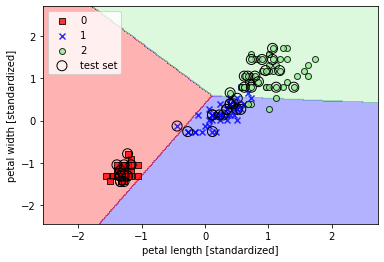

In [11]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()



# ロジスティック回帰

In [7]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

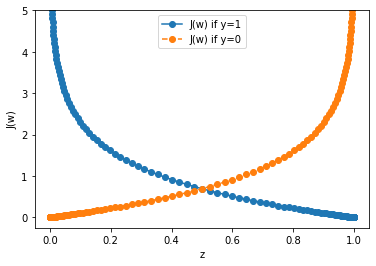

In [8]:
def cost_1(z):
    return -np.log(sigmoid(z))

def cost_0(z):
    return -np.log(1 - sigmoid(z))
z = np.arange(-10, 10, 0.1)

phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
c0 = [cost_0(x) for x in z]

plt.plot(phi_z, c1, label='J(w) if y=1', marker='o')
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0', marker='o')

plt.ylim(-0.25, 5.0)
plt.xlabel('z')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.show()


In [9]:
class LogisticRegressionGD:
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        return 1. / (1 + np.exp(-z))

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

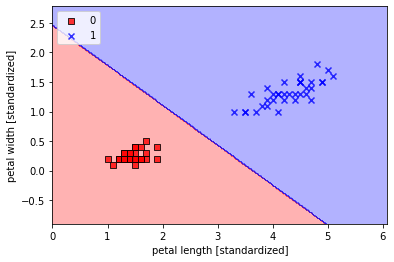

In [10]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()



# scikit-learn によるロジスティック回帰


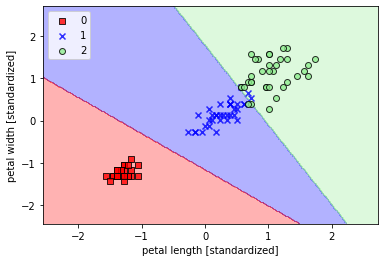

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

plot_decision_regions(X=X_train_std, y=y_train, classifier=lr)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()



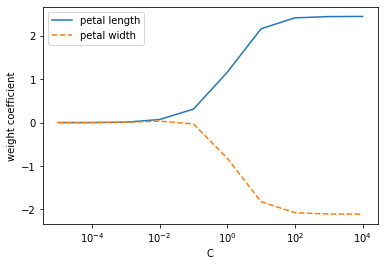

In [12]:
weights, params = [], []
for C in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**C, random_state=1, solver='lbfgs', multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**C)

weights = np.array(weights)
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()


# サポートベクターマシン

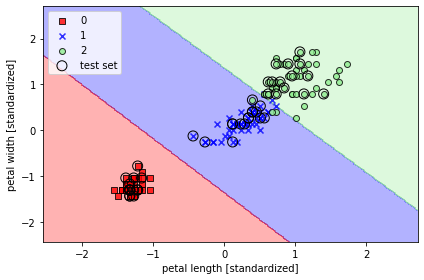

In [14]:

svm = SVC(kernel='linear', C=1.0, random_state=1)

svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105,150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


# カーネルトリックを用いた分離超平面

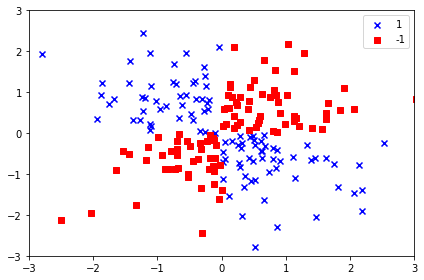

In [2]:
# データ生成
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:,0] > 0, X_xor[:,1] > 0) 
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='b', marker='x', label='1')
plt.scatter(X_xor[y_xor == -1, 0], X_xor[y_xor == -1, 1], c='r', marker='s', label='-1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()


c:\Users\yff68\anaconda3\envs\MachineLearning\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 36600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\yff68\anaconda3\envs\MachineLearning\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 36600 missing from current font.
  font.set_text(s, 0, flags=flags)


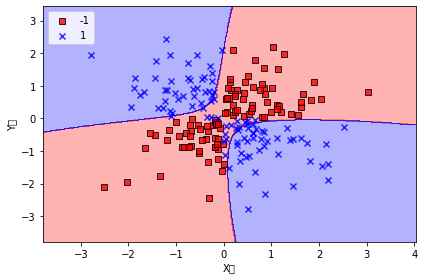

In [8]:
# RBFカーネルによるSVMインスタンスを生成
svm = SVC(kernel='rbf', C=10.0, random_state=1, gamma=0.10)
svm.fit(X_xor, y_xor)

# 決定領域をプロット
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.xlabel('X軸')
plt.ylabel('Y軸')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


# RBFカーネルによるSVMインスタンスを生成
svm = SVC(kernel='rbf', C=1.0, random_state=1, gamma=0.2)
svm.fit(X_train_std, y_train)

# 決定領域をプロット
plot_decision_regions(X_combined_std, y_combined, classifier=svm)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

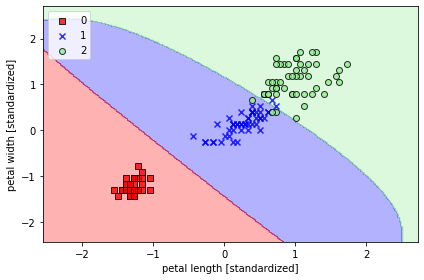

In [12]:
svm = SVC(kernel='rbf', C=1.0, random_state=1, gamma=0.2)
svm.fit(X_train_std, y_train)

# 決定領域をプロット
plot_decision_regions(X_combined_std, y_combined, classifier=svm)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

パラメータ変更　γ＝大　→　複雑、汎化誤差大きくなる

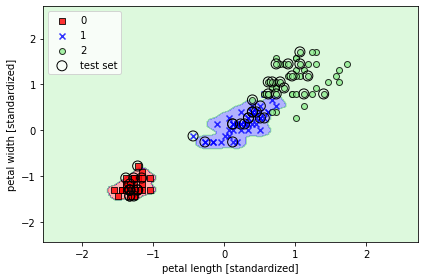

In [13]:
svm = SVC(kernel='rbf', C=1.0, random_state=1, gamma=100.0)
svm.fit(X_train_std, y_train)

# 決定領域をプロット
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#決定木学習

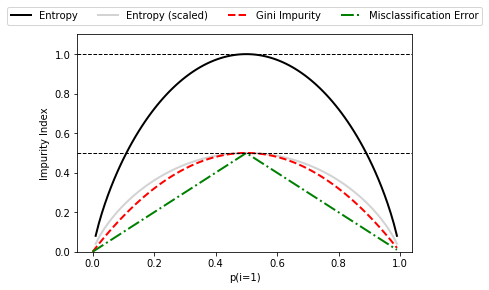

In [14]:
def gini(p):
    return (p)*(1-(p)) + (1-p)*(1-(1-p))

def entropy(p):
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

def error(p):
    return 1-np.max([p, 1-p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)

for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'], ['-', '-', '--', '-.'], ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()




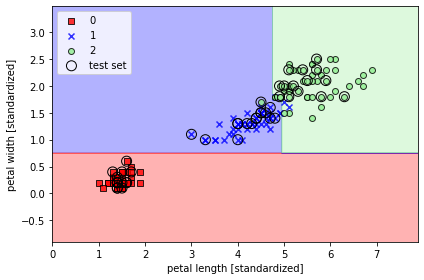

In [18]:
#決定木学習
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined, y_combined, classifier=tree_model, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

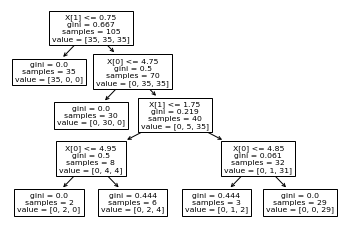

In [19]:
from sklearn import tree
tree.plot_tree(tree_model)
plt.show()


PyDotPlus は割愛

ｋ近傍法

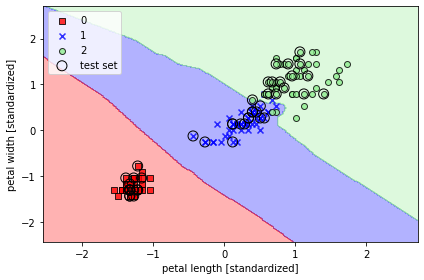

In [20]:
#ｋ近傍法
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=knn, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()